# 0.0. PREPARATION

## 0.1. Assumptions

Tenure -> time in months since customers joined the customer base

Balance -> amount of money spent by the customer

## 0.1. Imports

In [1]:
import pickle

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy                     import stats
from xgboost                   import XGBClassifier
from ydata_profiling           import ProfileReport
from IPython.core.display      import HTML
from sklearn.feature_selection import SelectFromModel


from sklearn  import metrics         as mt
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from sklearn  import linear_model    as lm
from sklearn  import preprocessing   as pp
from sklearn  import model_selection as ms
from imblearn import combine         as cb

## 0.2. Load Data

In [2]:
df_raw = pd.read_csv('../data/abandono_clientes.csv')

### 0.2.1. Split Test Data

In [3]:
df1, df_test = ms.train_test_split(df_raw, test_size=0.15)

## 0.3. Helper Functions

In [4]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()
    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        #x_val_fold['response'] = y_val_fold
        
        precision = mt.precision_score(y_val_fold, yhat_model)
        recall = mt.recall_score(y_val_fold, yhat_model)
        f1_score = mt.f1_score(y_val_fold, yhat_model, average='macro')
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_score_str = np.round(np.mean(f1_score_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_score_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)

    return models_performance

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

In [6]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2525,2526,15738411,Ho,505,France,Male,34,10,104498.79,1,0,1,126451.14,0
7195,7196,15708714,Santiago,675,France,Female,33,6,0.00,2,1,0,34045.61,0
5171,5172,15760849,Nwachukwu,537,France,Male,39,2,0.00,2,1,1,137651.60,0
5710,5711,15589496,Arrington,778,France,Male,34,5,139064.06,2,0,0,67949.32,0
3635,3636,15571689,Kelechi,740,France,Female,37,5,0.00,2,1,1,27528.40,0


## 1.1. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8500
Number of columns: 14


## 1.2. Data Types

In [8]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3. Checks

In [9]:
# check na
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# check duplicates
df1.duplicated().sum()

0

In [11]:
# check balance
df1['Exited'].value_counts(normalize=True)

0    0.795176
1    0.204824
Name: Exited, dtype: float64

## 1.4. Descriptive Analysis

In [12]:
num_attributes = df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
cat_attributes = df1[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 1.4.1. Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat metrics
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [14]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,CreditScore,350.00,850.00,500.00,650.288000,652.000,96.546955,-0.079656,-0.434723
1,Age,18.00,92.00,74.00,38.964000,37.000,10.515003,1.009129,1.391841
2,Tenure,0.00,10.00,10.00,5.025294,5.000,2.897495,0.009789,-1.167770
3,Balance,0.00,250898.09,250898.09,76318.508709,97258.330,62428.920050,-0.138168,-1.498279
4,NumOfProducts,1.00,4.00,3.00,1.531059,1.000,0.584184,0.764598,0.647211
5,EstimatedSalary,11.58,199992.48,199980.90,100428.050944,100523.305,57545.769224,-0.001521,-1.184096


### 1.4.2. Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

### 1.4.3. Pandas Profiling

In [16]:
# prof = ProfileReport(df1)
# prof.to_file(output_file='../reports/output.html')

**Notes From Pandas Profiling Report**

* Maximum value of CreditScore (850) is the most common.
* Column Age could be similar to normal distribution.
* Tenure has low variance.
* Lot of zeroes in Balance (36%).
* Some very low values in EstimatedSalary.
* Imbalanced problem (80/20)

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

In [18]:
# average ticket
df2['AvgTicket'] = [np.round(x['Balance'] / x['NumOfProducts'], 2) if x['NumOfProducts'] != 0 else 0 for _, x in df2.iterrows()]

# 3.0. DATA FILTERING

In [19]:
df3 = df2.copy()

In [20]:
# no outliers applied. Unused columns will be removed at data preparation

# 4.0. EXPLORATORY DATA ANALYSIS

In [21]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [22]:
num_attributes = df4[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AvgTicket']]
cat_attributes = df4[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 4.1.1. Response Variable

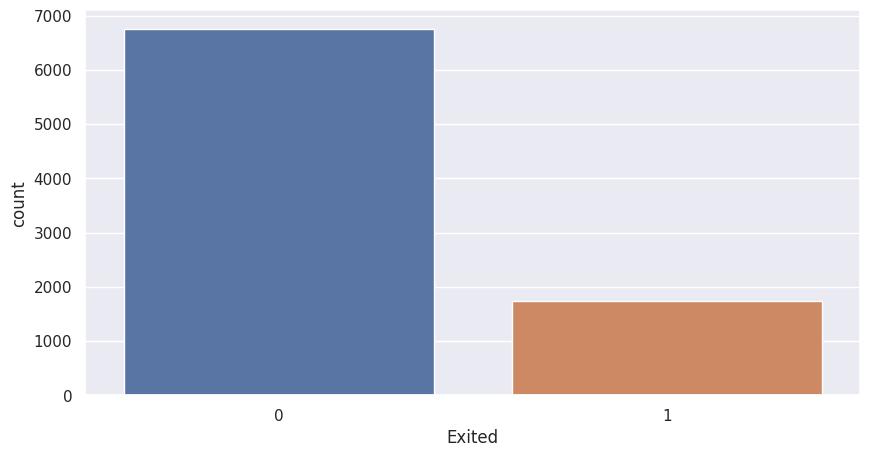

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='Exited', data=df4);

### 4.1.2. Numerical Variables

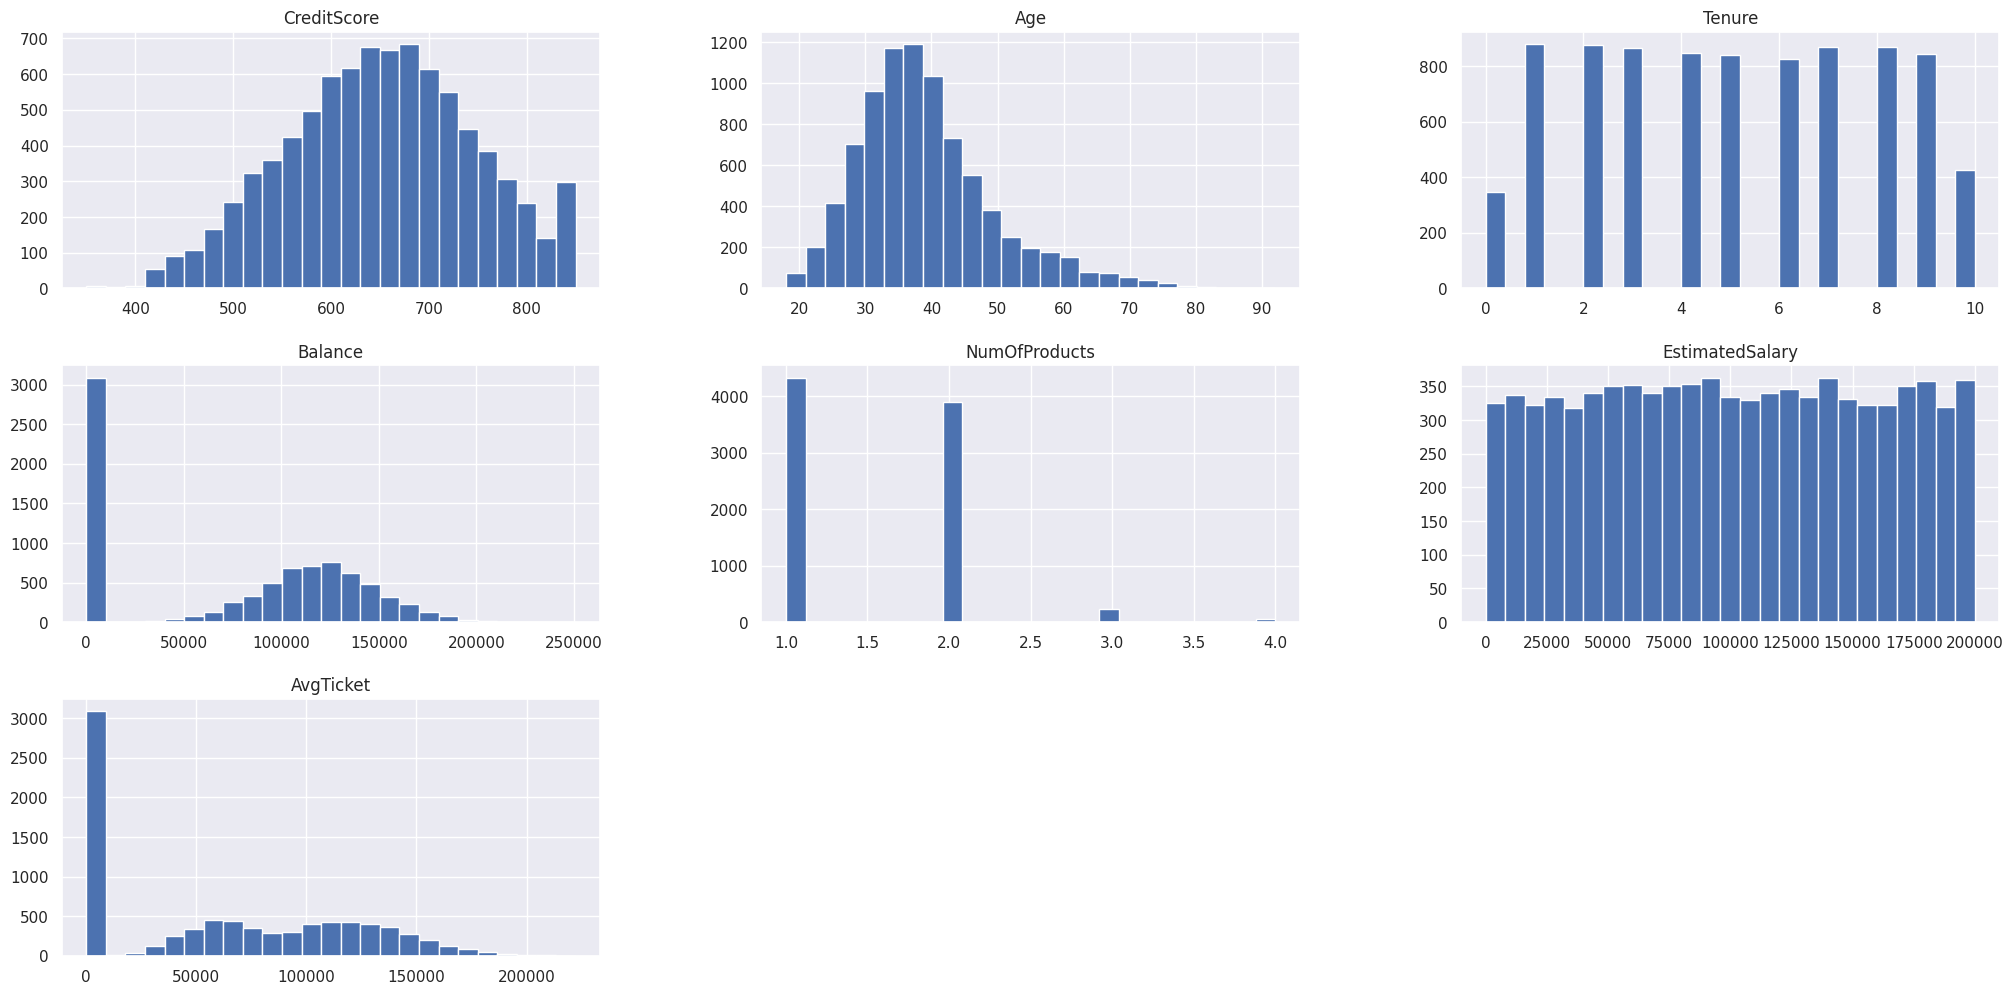

In [24]:
num_attributes.hist(bins=25);

/tmp/ipykernel_18918/2158198755.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


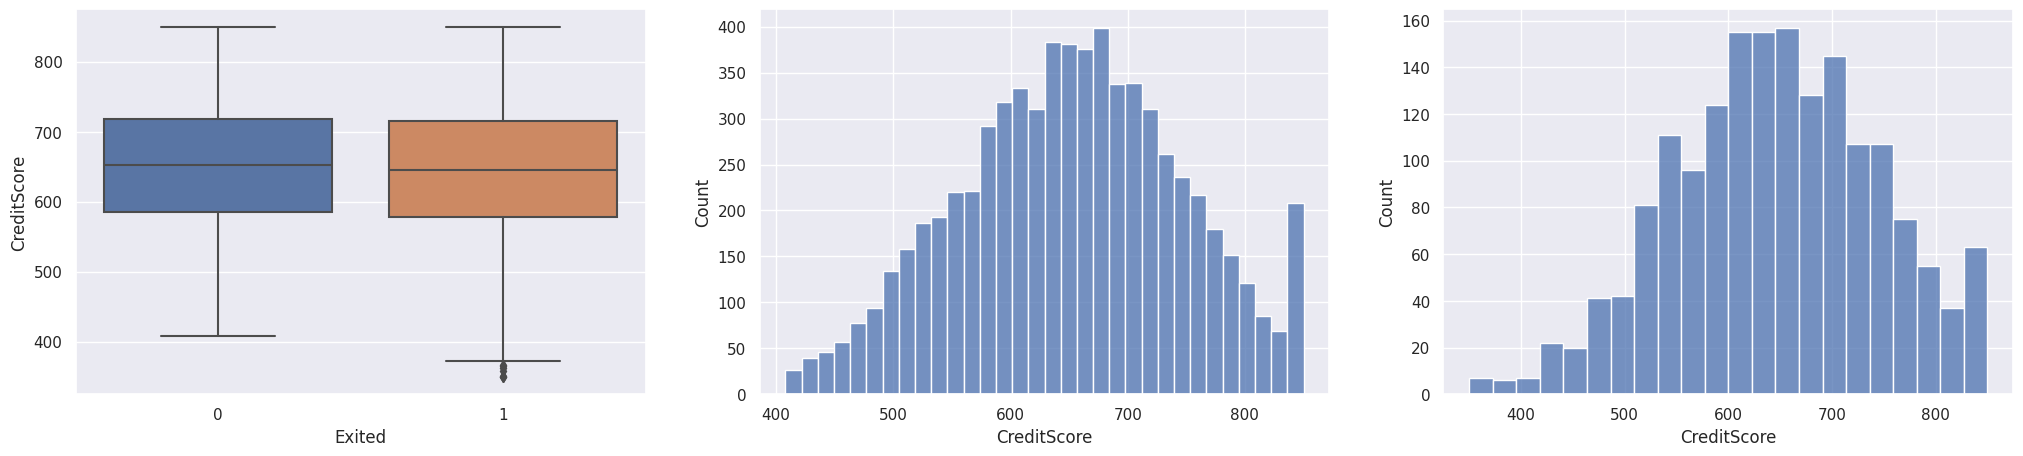

In [25]:
# Credit Score
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='CreditScore', data=df4);

plt.subplot(1,3,2)
CreditScore0 = df4.loc[df4['Exited'] == 0, 'CreditScore']
sns.histplot(CreditScore0);

plt.subplot(1,3,3)
CreditScore1 = df4.loc[df4['Exited'] == 1, 'CreditScore']
sns.histplot(CreditScore1);

/tmp/ipykernel_18918/1261668618.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


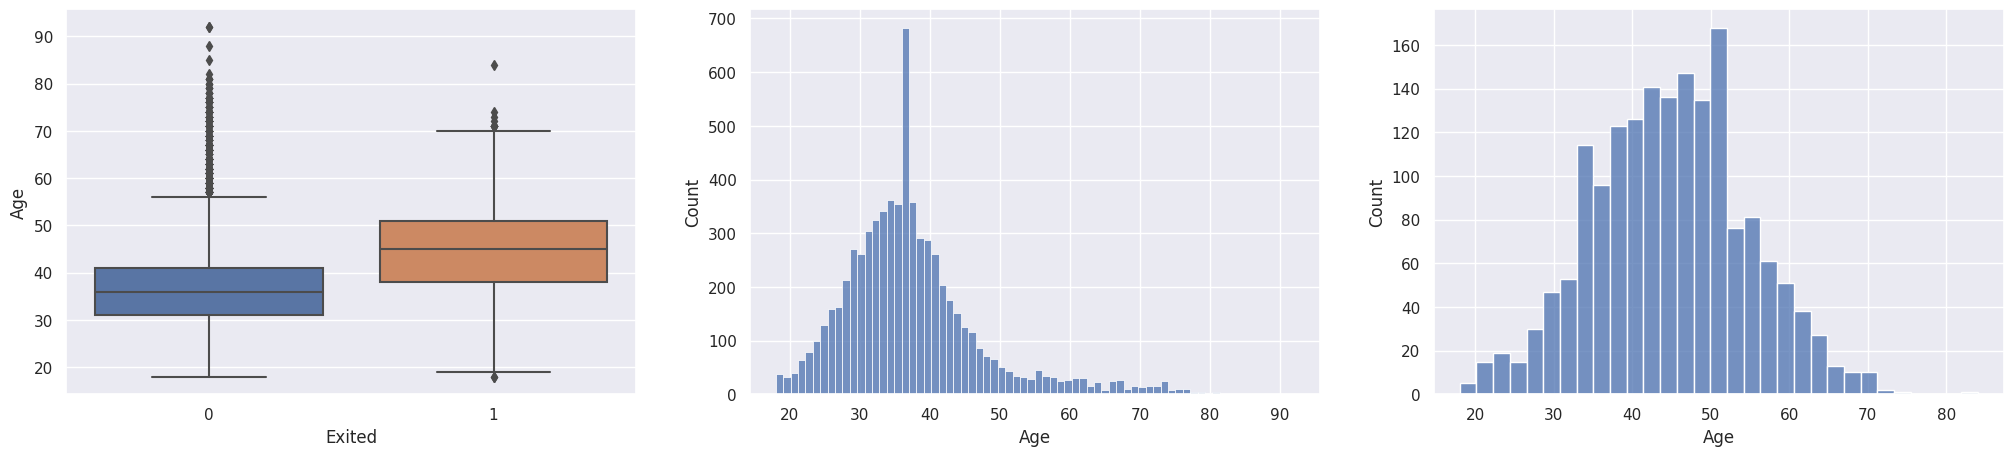

In [26]:
# Age
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Age', data=df4);

plt.subplot(1,3,2)
Age0 = df4.loc[df4['Exited'] == 0, 'Age']
sns.histplot(Age0);

plt.subplot(1,3,3)
Age1 = df4.loc[df4['Exited'] == 1, 'Age']
sns.histplot(Age1);

/tmp/ipykernel_18918/2524579783.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


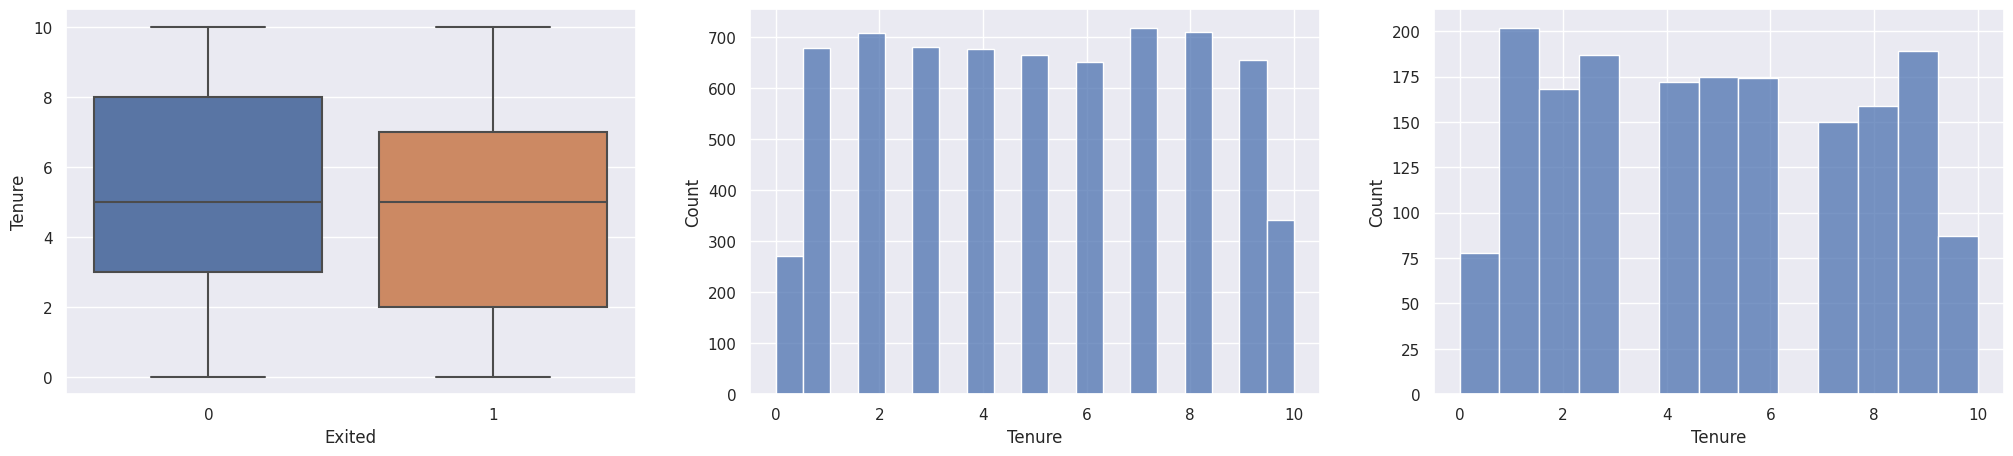

In [27]:
# Tenure
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Tenure', data=df4);

plt.subplot(1,3,2)
Tenure0 = df4.loc[df4['Exited'] == 0, 'Tenure']
sns.histplot(Tenure0);

plt.subplot(1,3,3)
Tenure1 = df4.loc[df4['Exited'] == 1, 'Tenure']
sns.histplot(Tenure1);

/tmp/ipykernel_18918/3530946033.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


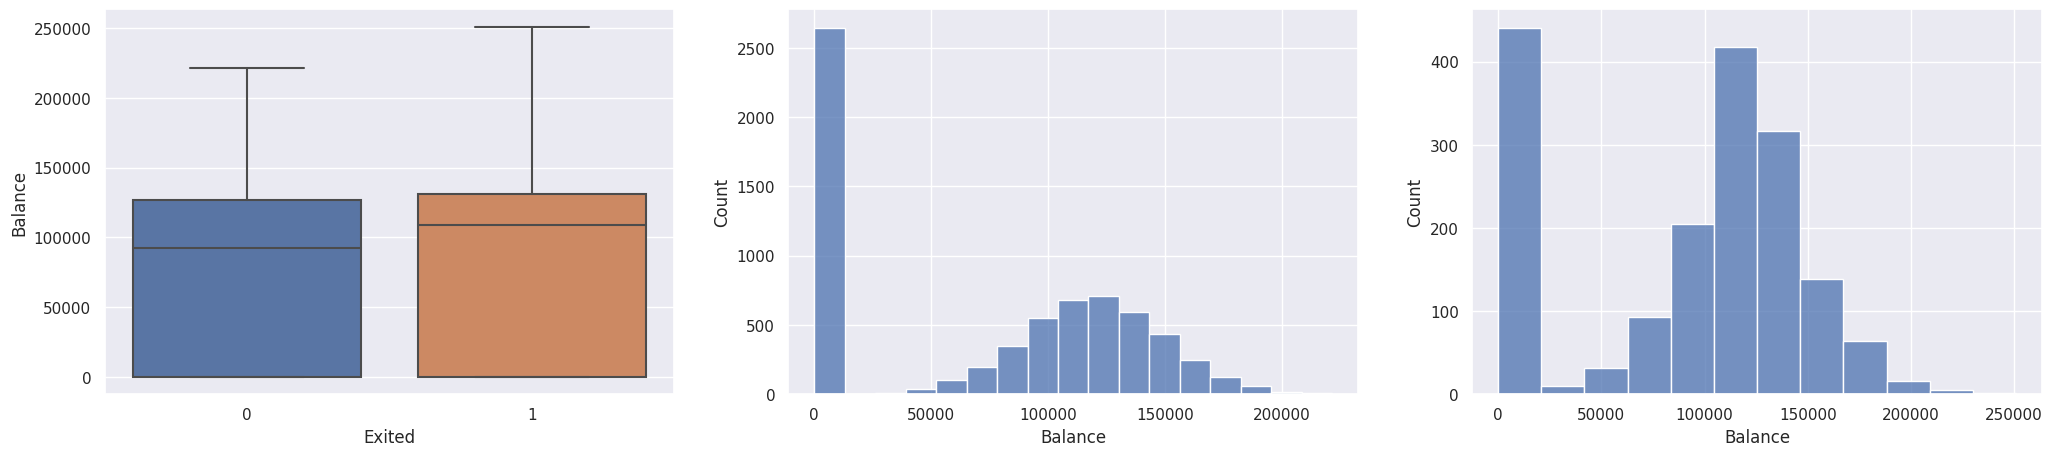

In [28]:
# Balance
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Balance', data=df4);

plt.subplot(1,3,2)
Balance0 = df4.loc[df4['Exited'] == 0, 'Balance']
sns.histplot(Balance0);

plt.subplot(1,3,3)
Balance1 = df4.loc[df4['Exited'] == 1, 'Balance']
sns.histplot(Balance1);

/tmp/ipykernel_18918/1650660008.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


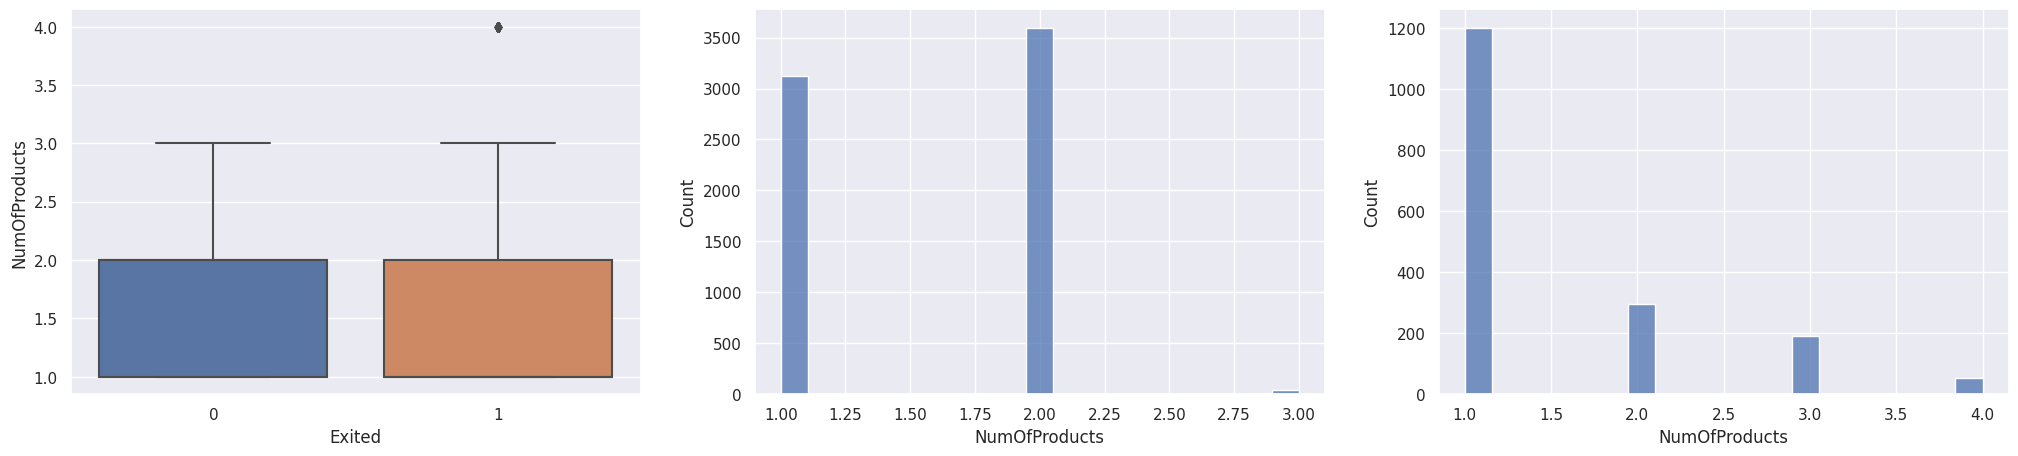

In [29]:
# NumOfProducts
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='NumOfProducts', data=df4);

plt.subplot(1,3,2)
NumOfProducts0 = df4.loc[df4['Exited'] == 0, 'NumOfProducts']
sns.histplot(NumOfProducts0);

plt.subplot(1,3,3)
NumOfProducts1 = df4.loc[df4['Exited'] == 1, 'NumOfProducts']
sns.histplot(NumOfProducts1);

/tmp/ipykernel_18918/238950735.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


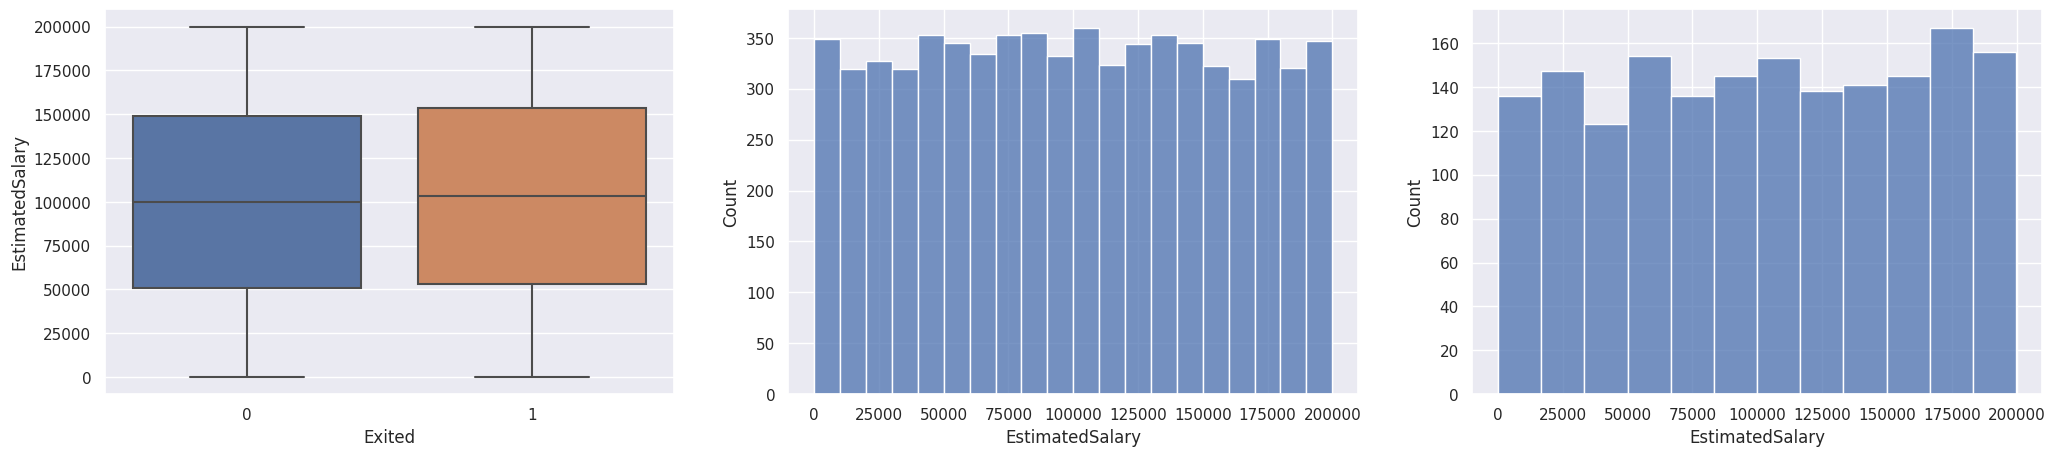

In [30]:
# EstimatedSalary
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='EstimatedSalary', data=df4);

plt.subplot(1,3,2)
EstimatedSalary0 = df4.loc[df4['Exited'] == 0, 'EstimatedSalary']
sns.histplot(EstimatedSalary0);

plt.subplot(1,3,3)
EstimatedSalary1 = df4.loc[df4['Exited'] == 1, 'EstimatedSalary']
sns.histplot(EstimatedSalary1);

/tmp/ipykernel_18918/3995312931.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


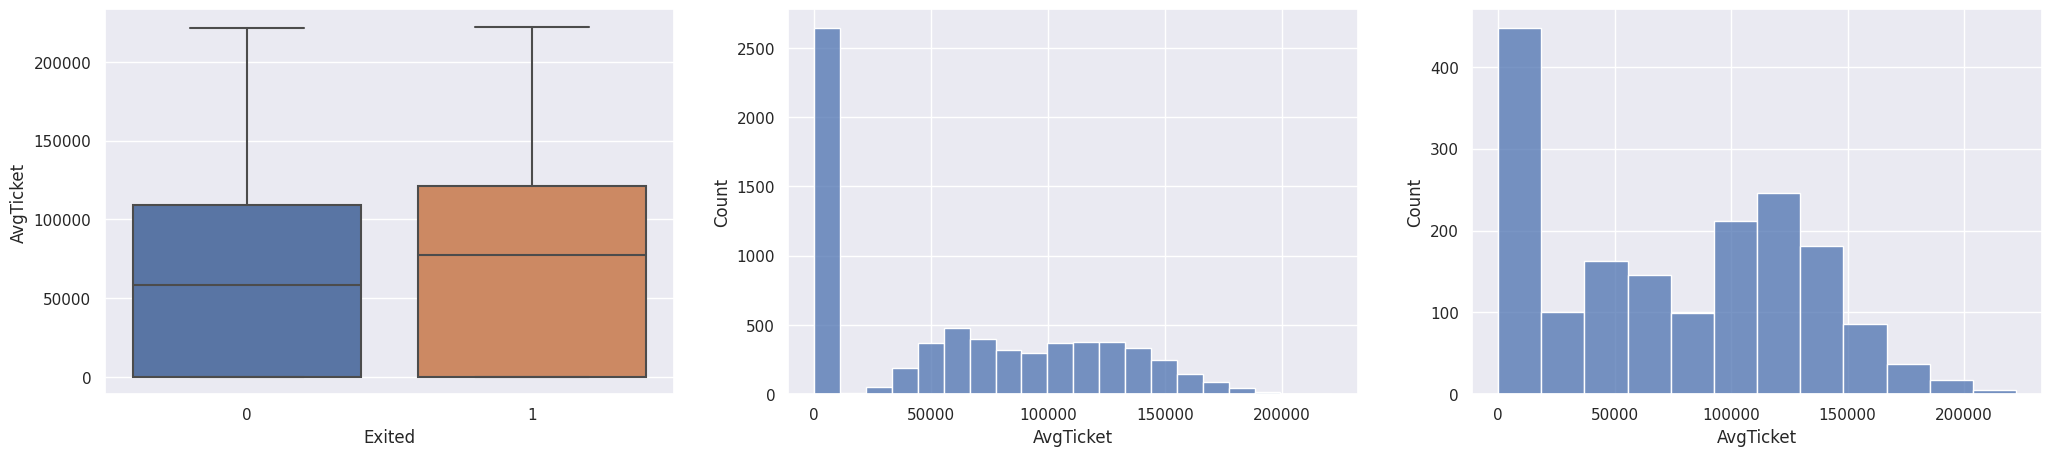

In [31]:
# AvgTicket
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='AvgTicket', data=df4);

plt.subplot(1,3,2)
AvgTicket0 = df4.loc[df4['Exited'] == 0, 'AvgTicket']
sns.histplot(AvgTicket0);

plt.subplot(1,3,3)
AvgTicket1 = df4.loc[df4['Exited'] == 1, 'AvgTicket']
sns.histplot(AvgTicket1);

### 4.1.3. Categorical Variables

In [32]:
df_churn = df4[df4['Exited'] == 1]
df_nchurn = df4[df4['Exited'] == 0]

/tmp/ipykernel_18918/710844022.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


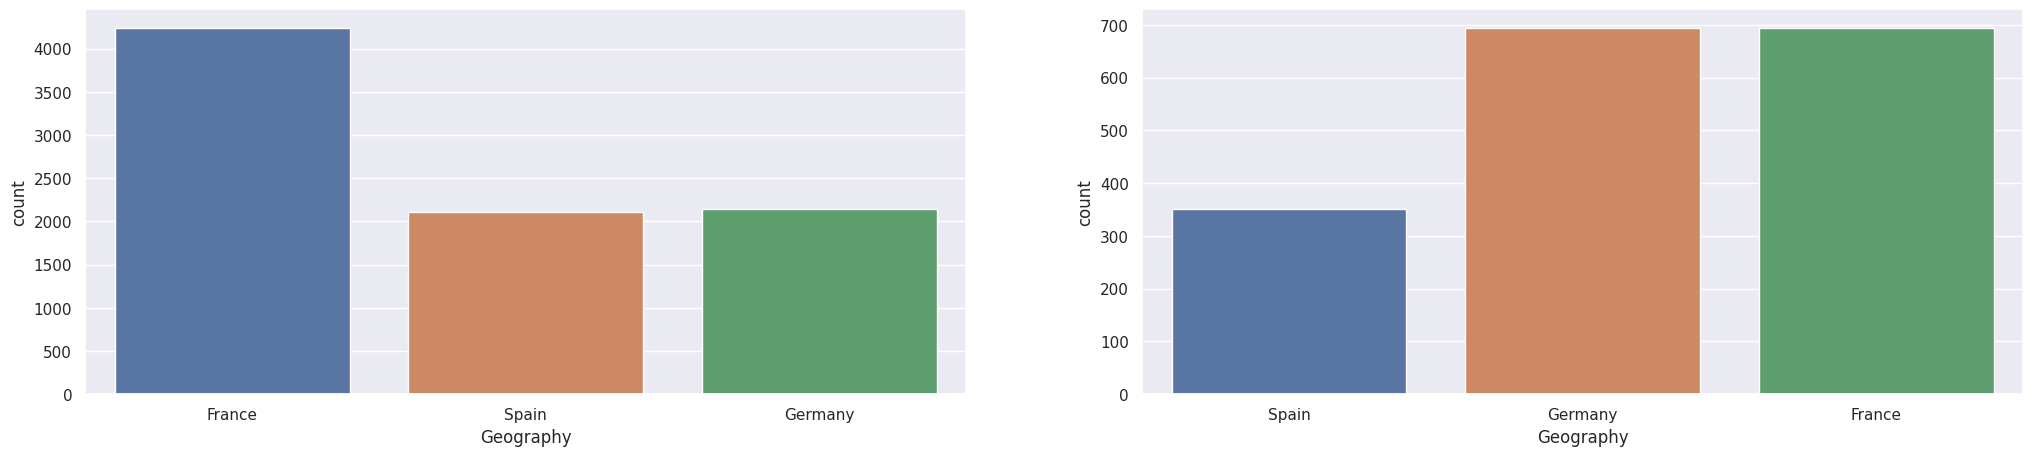

In [33]:
# geography
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Geography', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Geography', data=df_churn);

/tmp/ipykernel_18918/3242352414.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


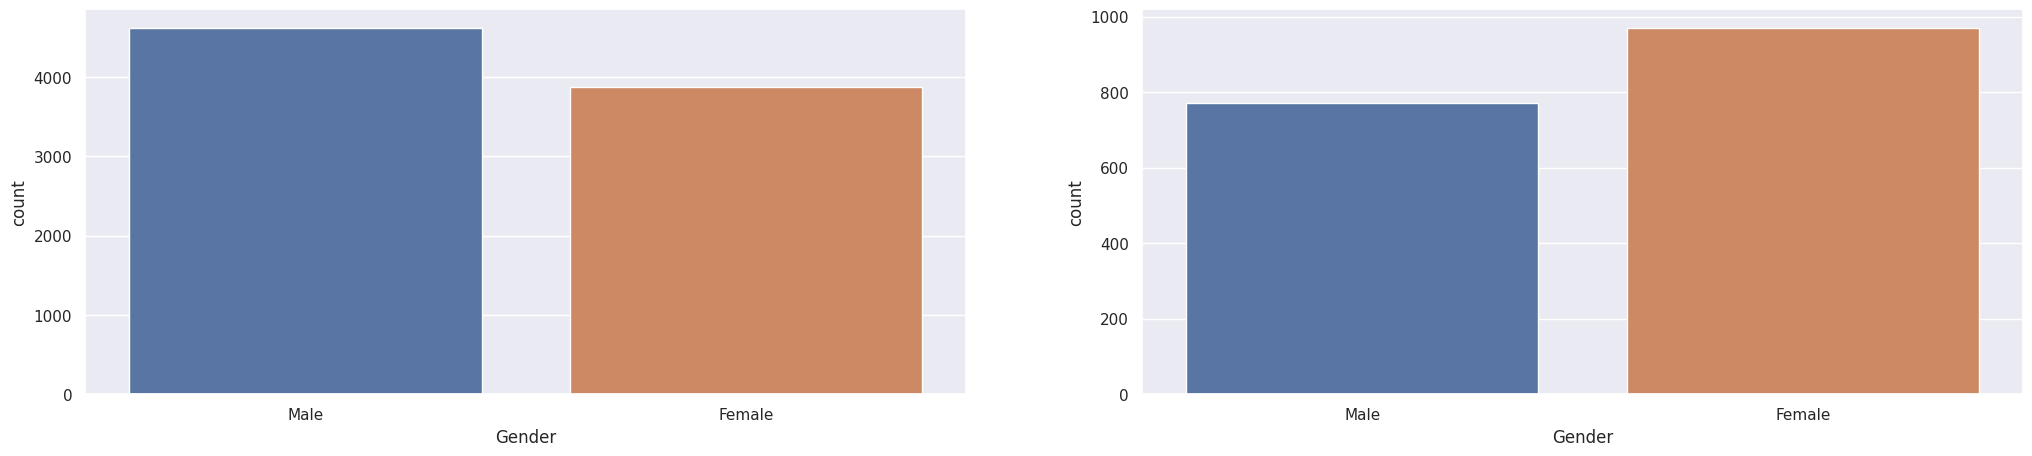

In [34]:
# gender
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Gender', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Gender', data=df_churn);

/tmp/ipykernel_18918/1413657579.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


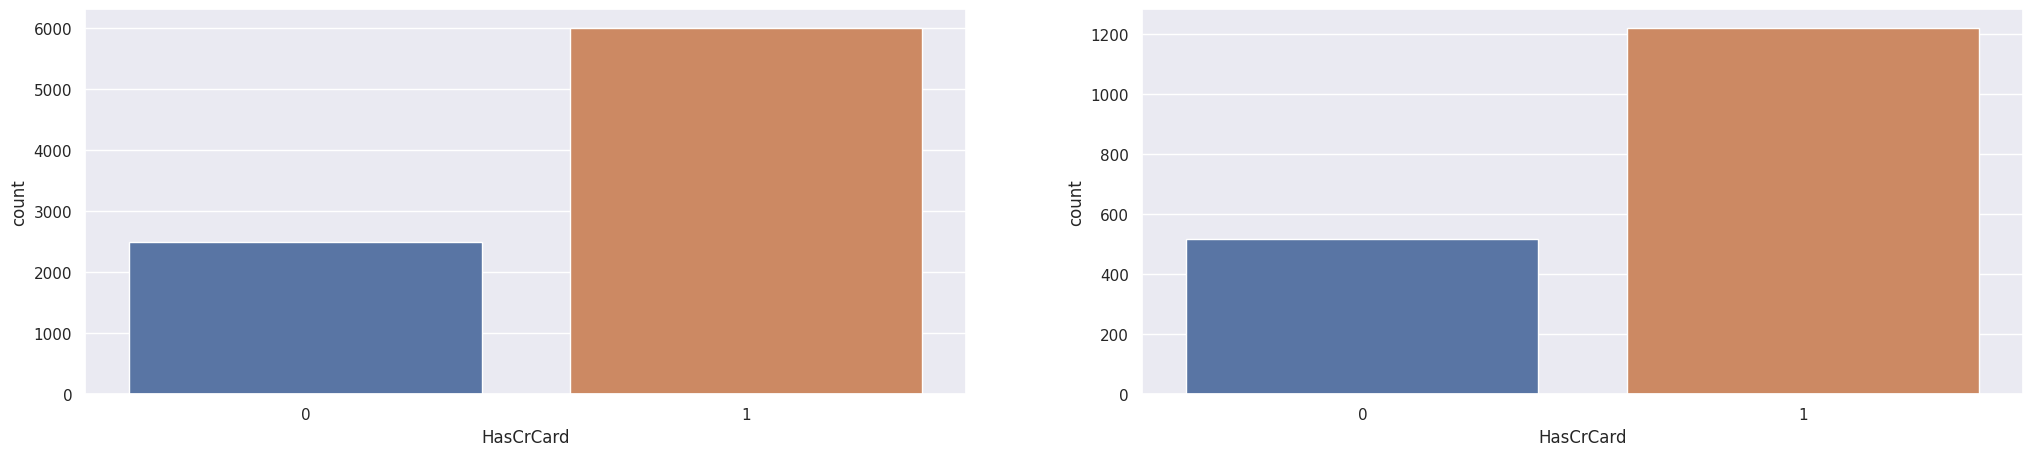

In [35]:
# has credit card
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='HasCrCard', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='HasCrCard', data=df_churn);

/tmp/ipykernel_18918/3152507493.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


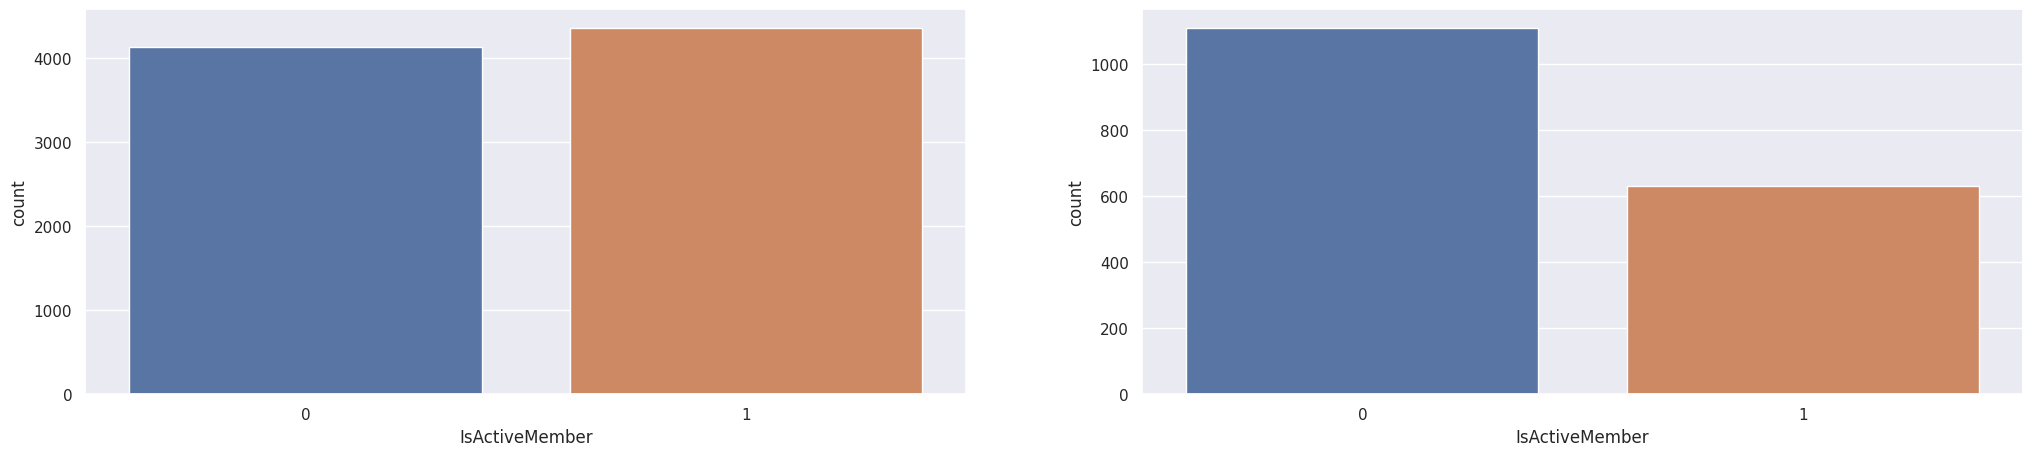

In [36]:
# is active
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='IsActiveMember', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='IsActiveMember', data=df_churn);

## 4.2. Bivariate Analysis

In [37]:
# create business hypotesis and validate with bivariate analysis

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

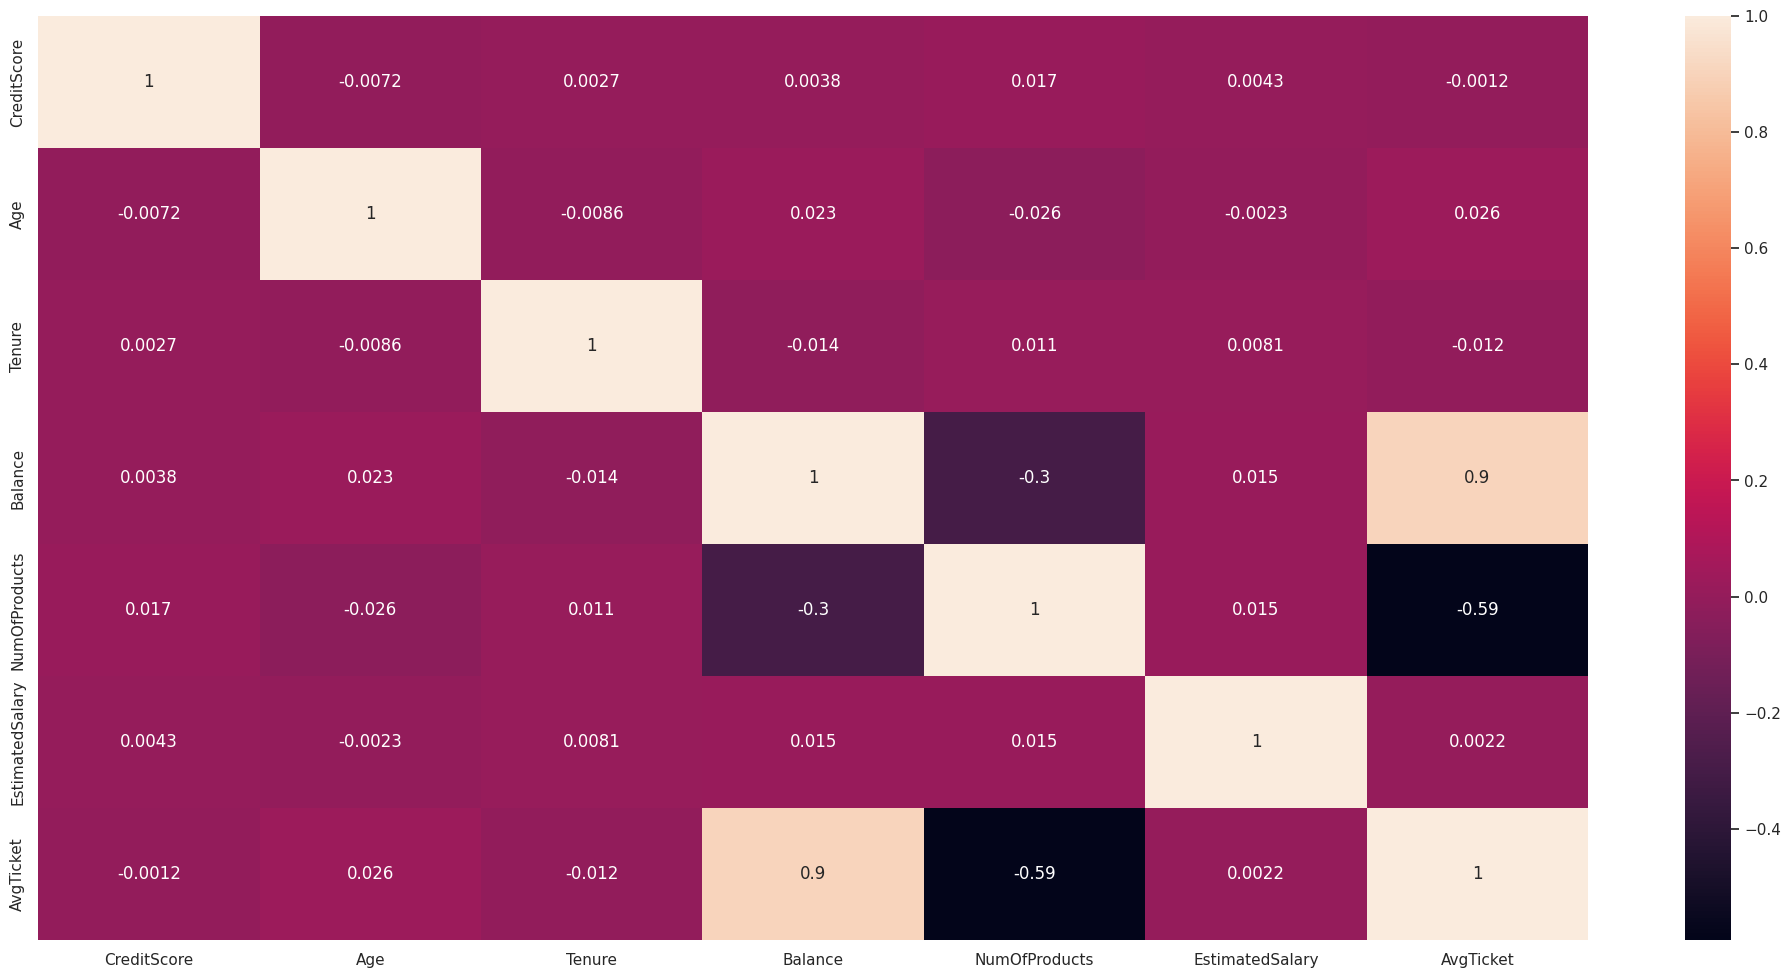

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Variables

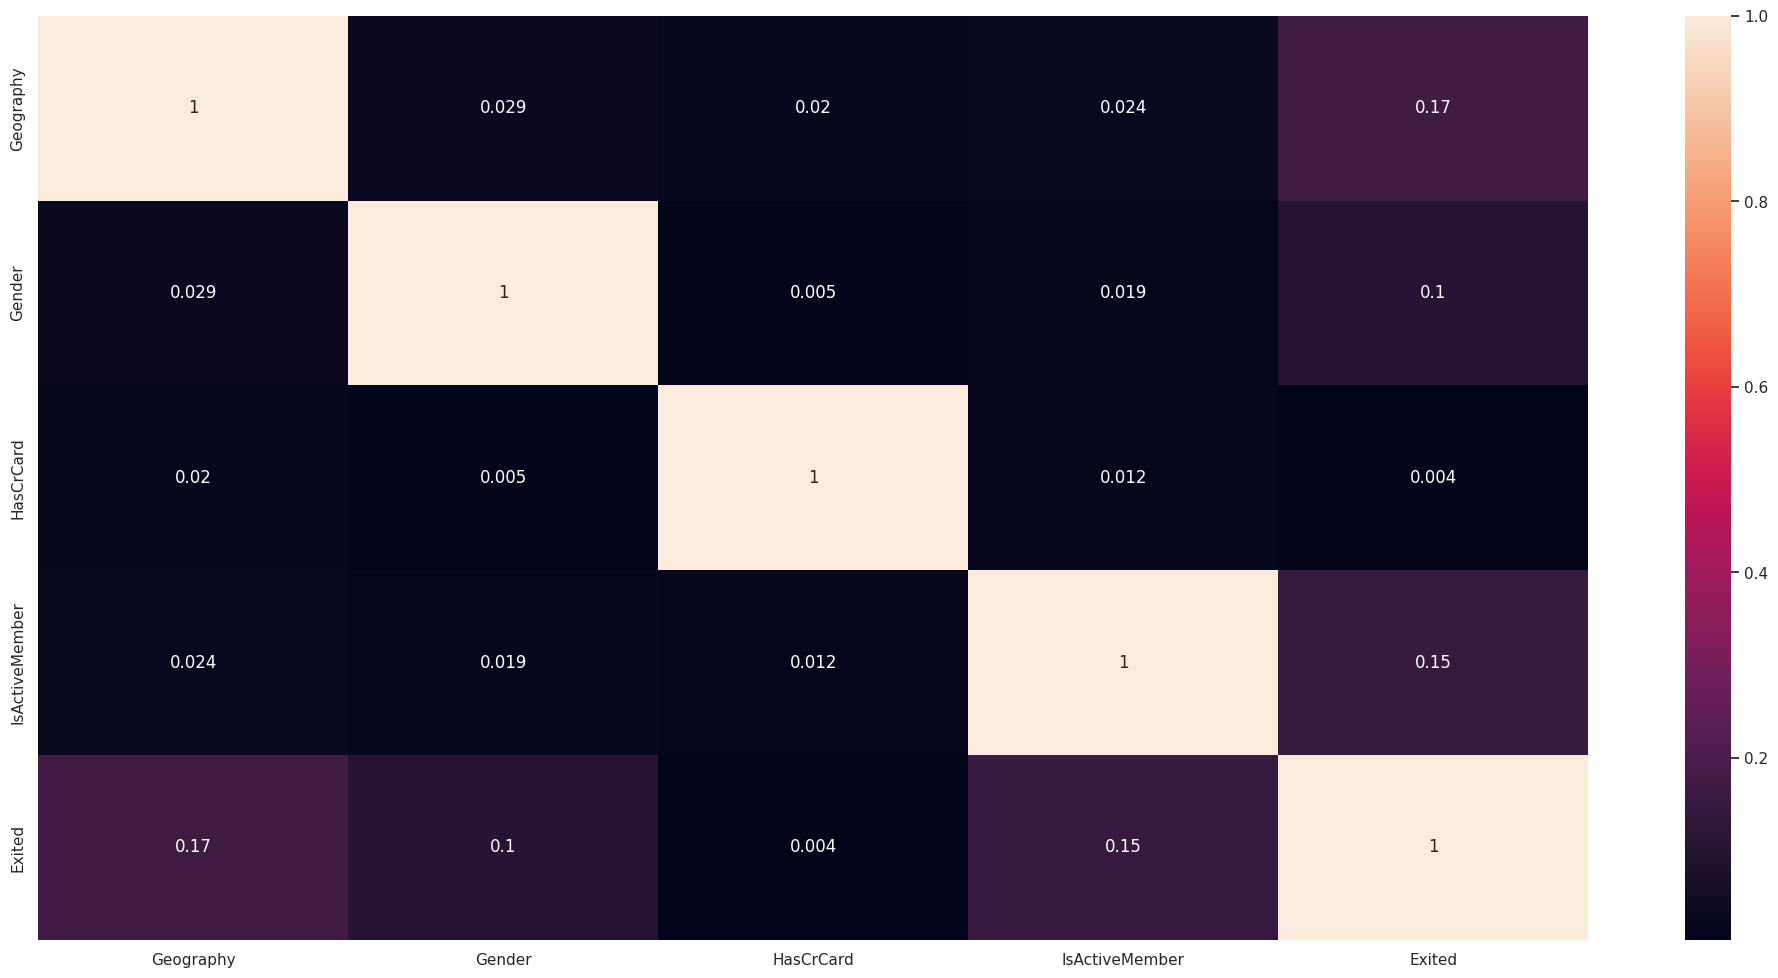

In [39]:
d = pd.DataFrame(corr_cramer_v(cat_attributes))
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);
# sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

In [40]:
d

,Geography,Gender,HasCrCard,IsActiveMember,Exited
Geography,1.000118,0.029089,0.020122,0.023650,0.171458
Gender,0.029089,0.999822,0.005049,0.019402,0.103128
HasCrCard,0.020122,0.005049,0.999775,0.012051,0.004006
IsActiveMember,0.023650,0.019402,0.012051,0.999823,0.153484
Exited,0.171458,0.103128,0.004006,0.153484,0.999698


# 5.0. BALANCED DATA

In [41]:
df5 = df4.copy()

In [42]:
# # geography - One Hot Encoding
# df5 = pd.get_dummies(df5, prefix='Geography', columns=['Geography'], dtype='int64')

# # gender- One Hot Encoding
# df5 = pd.get_dummies(df5, columns=['Gender'], dtype='int64')

In [43]:
# X = df5.drop(['Surname', 'Exited'], axis=1)
# y = df5['Exited']

In [44]:
# # SMOTE + Tomekling
# # define sampler
# smt = cb.SMOTETomek(sampling_strategy='auto', random_state=32)

# # apply sampler
# X_smt, y_smt = smt.fit_resample(X, y)

In [45]:
# df51 = pd.concat([X_smt, y_smt], axis=1)

# 6.0. DATA PREPARATION

In [46]:
#df6 = df51.copy()
df6 = df5.copy()

# drop customer id
df6.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

## 6.1. Standardization

In [47]:
# looking at session 4.1.2, the only feature that resemble a normal distribution is CredictScore
ss = pp.StandardScaler()

df6['CreditScore'] = ss.fit_transform(df6[['CreditScore']].values)
pickle.dump(ss, open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'wb'))

## 6.2. Rescaling

In [48]:
mm = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [49]:
# Age
df6['Age'] = rs.fit_transform(df6[['Age']].values)
pickle.dump(rs, open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'wb'))

# Tenure
df6['Tenure'] = mm.fit_transform(df6[['Tenure']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'wb'))

# Balance
df6['Balance'] = mm.fit_transform(df6[['Balance']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'wb'))

# Number of Products
df6['NumOfProducts'] = mm.fit_transform(df6[['NumOfProducts']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'wb'))

# Estimated Salary
df6['EstimatedSalary'] = mm.fit_transform(df6[['EstimatedSalary']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'wb'))

# Average Ticket
df6['AvgTicket'] = mm.fit_transform(df6[['AvgTicket']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'wb'))

## 6.3. Encoding

In [50]:
# geography - One Hot Encoding
df6 = pd.get_dummies(df6, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
df6 = pd.get_dummies(df6, columns=['Gender'], dtype='int64')

## 6.4. Train and Validation Split

In [51]:
# split training and validation datasets
X = df6.drop('Exited', axis=1)
y = df6['Exited'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# 7.0. FEATURE SELECTION

In [52]:
df7 = df6.copy()

## 7.1. Extra Tree Classifier

In [53]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# # data preparation
# x_train_n = df7.drop('Exited', axis=1)
# y_train_n = df7['Exited']
# forest.fit(x_train_n, y_train_n)

In [54]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # print the feature ranking
# print('Feature Ranking:')
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)
    
# print(df.sort_values('importance', ascending=False))

# # plot the impurity-based feature importance of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

# 8.0. MACHINE LEARNING MODELING

In [55]:
# # best features found by extra trees
# cols_selected_tree = ['Age', 'NumOfProducts', 'CreditScore', 'EstimatedSalary', 'AvgTicket', 'Balance', 'Tenure', 'BalanceMonth']

# cols_selected = ['CreditScore', 'Age', 'Tenure', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'AvgTicket', 'Geography_France', 'Geography_Germany', 
#                  'Geography_Spain', 'Gender_Female', 'Gender_Male']

## 8.1. Logistic Regression - Baseline

In [56]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict(x_validation)

In [57]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_lr)
recall = mt.recall_score(y_validation, yhat_lr)
f1_score = mt.f1_score(y_validation, yhat_lr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.51908
Recall: 0.18942
F1 Score: 0.57795


## 8.2. KNN

In [58]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction 
yhat_knn = knn_model.predict(x_validation)

In [59]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_knn)
recall = mt.recall_score(y_validation, yhat_knn)
f1_score = mt.f1_score(y_validation, yhat_knn, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.64336
Recall: 0.25627
F1 Score: 0.62840


## 8.3. Gradient Boosting

In [60]:
## model definition
gdr_model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
gdr_model.fit(x_train, y_train)

# model prediction
yhat_gdr = gdr_model.predict(x_validation)

In [61]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_gdr)
recall = mt.recall_score(y_validation, yhat_gdr)
f1_score = mt.f1_score(y_validation, yhat_gdr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.76020
Recall: 0.41504
F1 Score: 0.72330


## 8.4. Random Forest

In [62]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=None)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict(x_validation)

In [63]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_rf)
recall = mt.recall_score(y_validation, yhat_rf)
f1_score = mt.f1_score(y_validation, yhat_rf, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.74384
Recall: 0.42061
F1 Score: 0.72288


## 8.5. XGBoost

In [64]:
# model definition
xgb_model = XGBClassifier(max_delta_step=8, scale_pos_weight=0.8)

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict(x_validation)

In [65]:
# calculate metrics
precision = mt.precision_score(y_validation, yhat_xgb)
recall = mt.recall_score(y_validation, yhat_xgb)
f1_score = mt.f1_score(y_validation, yhat_xgb, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.70270
Recall: 0.43454
F1 Score: 0.72079


# 9.0. CROSS VALIDATION

In [66]:
# prepare cross validation data
x_train_cv = df6.drop('Exited', axis = 1)
y_train_cv = df6['Exited']


In [67]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision": [], "Recall": [], "F1_Score": []})
models_performance_cv = cross_validation(models_performance_cv, 5 , 'logistic_regression', lr_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'knn'                , knn_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'gradient_boosting'  , gdr_model, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'random_forest'      , rf_model , x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'xgboost_cv'         , xgb_model, x_train_cv, y_train_cv)

/tmp/ipykernel_18918/1574604759.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_18918/1574604759.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ignore_index=True)
/tmp/ipykernel_18918/1574604759.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_score_str], index=models_performance.columns), ig

In [68]:
models_performance_cv

,Model,Precision,Recall,F1_Score
0,logistic_regression,0.5893 +/- 0.0382,0.2051 +/- 0.0075,0.5963 +/- 0.0079
1,knn,0.6396 +/- 0.0334,0.3016 +/- 0.0051,0.6524 +/- 0.0059
2,gradient_boosting,0.7755 +/- 0.0382,0.4704 +/- 0.0177,0.7519 +/- 0.0145
3,random_forest,0.7623 +/- 0.0382,0.4739 +/- 0.0199,0.7508 +/- 0.0156
4,xgboost_cv,0.7273 +/- 0.019,0.4756 +/- 0.0185,0.7441 +/- 0.009


# 10.0. HYPERPARAMETER FINE TUNING

In [87]:
# random parameters ranges
param = {
    'n_estimators': [1500, 1700, 2500],
    'max_depth': [3, 5, 9],
    'min_samples_split': [2, 5, 7],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [88]:
rf_model = en.RandomForestClassifier()
rf_grid = ms.GridSearchCV(estimator = rf_model, param_grid = param, cv=3, verbose=2)

In [89]:
rf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   4.9s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   4.9s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   4.8s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   7.0s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   5.8s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   5.3s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.7s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.6s
[CV] END class_weight=None, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.8s
[CV] END class_weight=None, max_depth=

[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   4.6s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   4.6s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   5.2s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   5.2s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   5.3s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.7s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.6s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=2, n_estimators=2500; total time=   7.7s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=5, n_estimators=1500; total time=   4.6s
[CV] END class_weight=balanced, max_depth=3, min_samples_split=5

[CV] END class_weight=balanced, max_depth=9, min_samples_split=7, n_estimators=2500; total time=  12.3s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   6.3s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   6.3s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1500; total time=   6.5s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1700; total time=10.3min
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1700; total time=  10.3s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=1700; total time=   8.9s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=2500; total time=  12.3s
[CV] END class_weight=balanced_subsample, max_depth=3, min_samples_split=2, n_estimators=2500; tot

[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=5, n_estimators=2500; total time=  17.1s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1500; total time=  10.2s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1500; total time=  10.4s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1500; total time=  10.6s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1700; total time=  11.9s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1700; total time=  12.8s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=1700; total time=  12.6s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators=2500; total time=  17.7s
[CV] END class_weight=balanced_subsample, max_depth=9, min_samples_split=7, n_estimators

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [3, 5, 9], 'min_samples_split': [2, 5, 7],
                         'n_estimators': [1500, 1700, 2500]},
             verbose=2)

In [91]:
rf_grid.best_params_

{'class_weight': None,
 'max_depth': 9,
 'min_samples_split': 7,
 'n_estimators': 1500}

In [73]:
# best parametes for balanced data
# {'class_weight': 'balanced',
#  'max_depth': 9,
#  'min_samples_split': 5,
#  'n_estimators': 1500}

# best paramater for imbalanced data
# {'class_weight': None,
#  'max_depth': 9,
#  'min_samples_split': 7,
#  'n_estimators': 1500}

# 10.0. MODEL PERFORMANCE

## 10.1. Retrain Model With All Data

In [102]:
# concat training and validation datasets
x_retrain = pd.concat([x_train, x_validation])
y_retrain = pd.concat([y_train, y_validation])

In [103]:
# model definition
def_model = en.RandomForestClassifier(n_estimators=1500, class_weight='balanced', max_depth=9, min_samples_split=7)

# model training
def_model.fit(x_retrain, y_retrain)

# # model prediction
# yhat_rf = rf_model.predict(x_validation)

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=7, n_estimators=1500)

In [104]:
# ## model definition
# model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# # model training
# model.fit(x_retrain, y_retrain)

# # # model prediction
# # yhat_gdr = gdr_model.predict(x_validation)

## 9.2. Test Dataset Preparation

In [105]:
df_test = df_test.copy()

In [106]:
# split response variable
x_test = df_test.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis = 1)
y_test = df_test['Exited']

In [107]:
x_test['AvgTicket'] = [np.round(x['Balance'] / x['NumOfProducts'], 2) if x['NumOfProducts'] != 0 else 0 for _, x in x_test.iterrows()]

In [108]:
# loade pickle scalers
CreditScoreScaler     = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'rb'))
AgeScaler             = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'rb'))
TenureScaler          = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'rb'))
BalanceScaler         = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'rb'))
NumOfProductsScaler   = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'rb'))
EstimatedSalaryScaler = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'rb'))
AvgTicketScaler       = pickle.load(open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'rb'))

In [109]:
# standardization

# CreditScore
x_test['CreditScore'] = CreditScoreScaler.transform(x_test[['CreditScore']].values)

# Age
x_test['Age'] = AgeScaler.transform(x_test[['Age']].values)

# Tenure
x_test['Tenure'] = TenureScaler.transform(x_test[['Tenure']].values)

# Balance
x_test['Balance'] = BalanceScaler.transform(x_test[['Balance']].values)

# NumOfProducts
x_test['NumOfProducts'] = NumOfProductsScaler.transform(x_test[['NumOfProducts']].values)

# EstimatedSalary
x_test['EstimatedSalary'] = EstimatedSalaryScaler.transform(x_test[['EstimatedSalary']].values)

# AvgTicket
x_test['AvgTicket'] = AvgTicketScaler.transform(x_test[['AvgTicket']].values)

# geography - One Hot Encoding
x_test = pd.get_dummies(x_test, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
x_test = pd.get_dummies(x_test, columns=['Gender'], dtype='int64')

In [110]:
# apply retrained model
pred_test = def_model.predict(x_test)

In [111]:
# performance
# calculate metrics
precision = mt.precision_score(y_test, pred_test)
recall = mt.recall_score(y_test, pred_test)
f1_score = mt.f1_score(y_test, pred_test, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.61920
Recall: 0.67568
F1 Score: 0.77711


In [84]:
# results with balanced data
# Precision: 0.63309
# Recall: 0.55346
# F1 Score: 0.74455

# results with imbalanced data and no finetuning
# Precision: 0.62579
# Recall: 0.67230
# F1 Score: 0.77884
